<a href="https://colab.research.google.com/github/musmeong/bangkit-assignment-5/blob/master/Fake_Job_Post_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Run on TensorFlow 2.0
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold

In [3]:
print(tf.__version__)

1.15.2


Installing PyDrive to Access the Data from Google Drive. We can't use Github in this case because the filesize is more than 25 MB.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1ZVE012JJ2nusDk706Ry7-EWHn9gi53Ui'}) 
downloaded.GetContentFile('fake_job_postings.csv') 
df = pd.read_csv('fake_job_postings.csv')

In [208]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [209]:
# Get all true job post
positive = df[df['fraudulent'] == 0]
print('Positive Job Post：', len(positive))

# Get all fake job post
negative = df[df['fraudulent'] == 1]
print('Negative Job Post：', len(negative))

Positive Job Post： 17014
Negative Job Post： 866


In [210]:
# NaN Value in All Column. We don't have any NaN value in label.
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [0]:
df = df.drop('job_id', axis=1)

In [0]:
cols = ["title", "company_profile", "description", "requirements", "benefits"]
for c in cols:
    df[c] = df[c].fillna("")

def extract_features(df):    
    for c in cols:
        df[c+"_length"] = df[c].apply(lambda x : len(str(x)))
        df[c+"_wordcount"] = df[c].apply(lambda x : len(str(x.split())))

    
extract_features(df)

In [0]:
df['combined_text'] = df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits']

n_features = {
    "title" : 100,
    "combined_text" : 500
}

for c, n in n_features.items():
    tfidf = TfidfVectorizer(max_features=n, norm='l2', stop_words = 'english')
    tfidf.fit(df[c])
    tfidf_train = np.array(tfidf.transform(df[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c]):
        df[c + '_tfidf_' + str(i)] = tfidf_train[:, i]

In [0]:
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]
for c in cat_cols:
    encoded = pd.get_dummies(df[c])
    df = pd.concat([df, encoded], axis=1)

In [217]:
df['Length'] = [len(jobpost) for jobpost in df['combined_text'].fillna('')]
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,title_length,title_wordcount,company_profile_length,company_profile_wordcount,description_length,description_wordcount,requirements_length,requirements_wordcount,benefits_length,benefits_wordcount,combined_text,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,title_tfidf_10,title_tfidf_11,...,Wireless,Writing and Editing,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,Consulting,Customer Service,Data Analyst,Design,Distribution,Education,Engineering,Finance,Financial Analyst,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,Length
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,16,23,885,1309,905,1278,852,1198,0,2,"We're Food52, and we've created a groundbreaki...",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2645
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,41,60,1286,1745,2077,3020,1433,2033,1292,1972,"90 Seconds, the worlds Cloud Video Production ...",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6091
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,39,52,879,1302,355,506,1363,1856,0,2,Valor Services provides Workforce Solutions th...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2600
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,33,49,614,868,2600,3637,1429,1958,782,1074,Our passion for improving quality of life thro...,0.0,0.0,0.0,0.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5428
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,19,29,1628,2250,1520,1939,757,1025,21,31,SpotSource Solutions LLC is a Global Human Cap...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3929


In [0]:
detail = df['Length'].describe()

# token字典數量 (最常出現的4000字) (Create a token dictionary)
token_num = 4000 

# 擷取多少固定長度字數 (抓標題字數的平均值 72個長度)
# (Get a fix length, we chose the mean of the Headline length)
data_length = int(detail['mean'])

# 輸入向量維度 (Word Embeding output vector dimension)
output_length = 32 

dropout = 0.5
lstm_dim = 256

In [220]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
token = Tokenizer(num_words = token_num, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
token.fit_on_texts(x_train_data)

In [0]:
x_train_seq = token.texts_to_sequences(x_train_data)
x_test_seq = token.texts_to_sequences(x_test_data)

In [0]:
x_train = sequence.pad_sequences(x_train_seq, maxlen = data_length)
x_test = sequence.pad_sequences(x_test_seq, maxlen = data_length)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping


In [224]:
model = Sequential()
model.add(Embedding(output_dim = output_length, input_dim = token_num, input_length = data_length))
model.add(Dropout(dropout))

# using BLSTM (this will be better than LSTM, Avg acc is around 0.94
model.add(Bidirectional(LSTM(lstm_dim), merge_mode = 'sum'))
model.add(Dropout(dropout))

# using LSTM, Avg acc is around 0.93
# model.add(LSTM(lstm_dim))
# model.add(Dropout(dropout))

model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(dropout))

model.add(Dense(units = 1, activation = 'sigmoid'))
print(model.summary())



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2640, 32)          128000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2640, 32)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               591872    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
___

In [225]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
# 提早結束
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 2)

In [235]:
train_history = model.fit(x = x_train_data,
                         y = y_train_data,
                         validation_split = 0.2,
                         epochs = 20,
                         batch_size = 512,
                         verbose = 1,
                         callbacks = [es])

ValueError: ignored

In [236]:
y_train_data

9859     0
552      0
2383     0
13391    0
5115     1
        ..
4704     0
11877    0
5354     0
8349     0
3832     0
Name: fraudulent, Length: 14304, dtype: int64

In [232]:
y_train_data.shape

(14304,)

In [192]:
drop_cols = ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'combined_text']
drop_cols += cat_cols
df = df.drop(drop_cols, axis = 1)
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,title_length,title_wordcount,company_profile_length,company_profile_wordcount,description_length,description_wordcount,requirements_length,requirements_wordcount,benefits_length,benefits_wordcount,combined_text_tfidf_0,combined_text_tfidf_1,combined_text_tfidf_2,combined_text_tfidf_3,combined_text_tfidf_4,combined_text_tfidf_5,combined_text_tfidf_6,combined_text_tfidf_7,combined_text_tfidf_8,combined_text_tfidf_9,combined_text_tfidf_10,combined_text_tfidf_11,combined_text_tfidf_12,combined_text_tfidf_13,combined_text_tfidf_14,combined_text_tfidf_15,combined_text_tfidf_16,combined_text_tfidf_17,combined_text_tfidf_18,combined_text_tfidf_19,combined_text_tfidf_20,combined_text_tfidf_21,combined_text_tfidf_22,combined_text_tfidf_23,combined_text_tfidf_24,combined_text_tfidf_25,...,Wine and Spirits,Wireless,Writing and Editing,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,Consulting,Customer Service,Data Analyst,Design,Distribution,Education,Engineering,Finance,Financial Analyst,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,0,1,0,0,16,23,885,1309,905,1278,852,1198,0,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,41,60,1286,1745,2077,3020,1433,2033,1292,1972,0.109741,0.0,0.043854,0.0,0.0,0.0,0.0,0.0,0.0,0.042206,0.025177,0.0,0.046692,0.047058,0.510254,0.012421,0.014786,0.0,0.0,0.021545,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,39,52,879,1302,355,506,1363,1856,0,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,33,49,614,868,2600,3637,1429,1958,782,1074,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.049316,0.000000,0.000000,0.026245,0.000000,0.0,0.0,0.409912,0.0,0.049927,0.0,0.044067,0.058044,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,1,0,19,29,1628,2250,1520,1939,757,1025,21,31,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.036621,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.068054,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [193]:
test_split = 0.2
train_split = 1 - test_split

# We will have 20% of all data for Testing, and 80% for Training)
train_data = df.sample(frac = train_split)
test_data = df.drop(train_data.index)

x_train_data = train_data.iloc[:,0:-1].fillna('')
y_train_data = train_data['fraudulent']
x_test_data = test_data.iloc[:,0:-1].fillna('')
y_test_data = test_data['fraudulent']

print('Train Data Feature Length：', len(x_train_data))
print('Train Data Label Length：', len(y_train_data))
print('Test Data Feature Length：', len(x_test_data))
print('Test Data Label Length：', len(y_test_data))

Train Data Feature Length： 14304
Train Data Label Length： 14304
Test Data Feature Length： 3576
Test Data Label Length： 3576


In [0]:
# Define the learning rate，batch_size, iter_num, etc.
learning_rate = 0.003
batch_size = 10
iter_num = 1500
m, n = x_train_data.shape 

In [0]:
# Building model and declare variable that will be learned
# Because we have such n columns in our new dataframe, then we use the value to declare A
A = tf.Variable(tf.random.normal(shape=[n, 1]))
b = tf.Variable(tf.random.normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
# Define placeholders for both the feature and label
data = tf.placeholder(dtype=tf.float32, shape=[None, n])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [0]:
# Declare the model for learning
mod = tf.matmul(data, A) + b

In [0]:
# Declare loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [0]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [0]:
# Define the goal
goal = opt.minimize(loss)

In [0]:
# Define the accuracy (default threshold is 0.5)
prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

In [0]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [203]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(x_train_data), size=batch_size)
    batch_train_X = x_train_data.iloc[batch_index]
    batch_train_y = np.matrix(y_train_data.iloc[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: x_train_data, target: np.matrix(y_train_data).T})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: x_train_data, target: np.matrix(y_train_data).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: x_test_data, target: np.matrix(y_test_data).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 100 == 0:
      print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  100 loss: 274.105072 train_acc: 0.951552 test_acc: 0.951622
epoch:  200 loss: 653.129028 train_acc: 0.951552 test_acc: 0.951622
epoch:  300 loss: 44.244896 train_acc: 0.946239 test_acc: 0.944351
epoch:  400 loss: 319.350891 train_acc: 0.951622 test_acc: 0.951622
epoch:  500 loss: 161.027328 train_acc: 0.951622 test_acc: 0.951622
epoch:  600 loss: 256.517181 train_acc: 0.951622 test_acc: 0.951622
epoch:  700 loss: 131.754364 train_acc: 0.947637 test_acc: 0.946868
epoch:  800 loss: 146.074310 train_acc: 0.951622 test_acc: 0.951622
epoch:  900 loss: 88.270660 train_acc: 0.951902 test_acc: 0.949664
epoch: 1000 loss: 340.957916 train_acc: 0.951063 test_acc: 0.951063
epoch: 1100 loss: 178.754715 train_acc: 0.951692 test_acc: 0.951902
epoch: 1200 loss: 148.318893 train_acc: 0.950643 test_acc: 0.949105
epoch: 1300 loss: 629.140747 train_acc: 0.951622 test_acc: 0.951622
epoch: 1400 loss: 180.964203 train_acc: 0.948056 test_acc: 0.946868
epoch: 1500 loss: 302.204071 train_acc: 0.950433 t

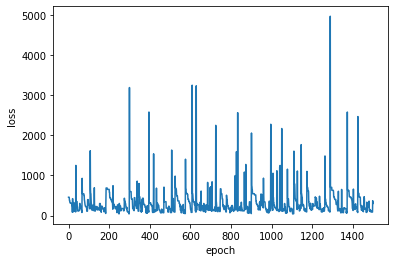

In [204]:
# Visualization of the results
plt.plot(loss_trace)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

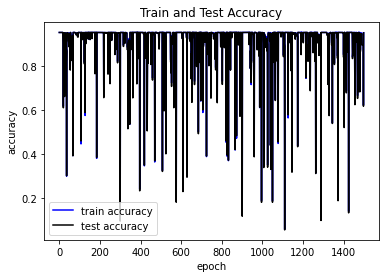

In [205]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()